In [1]:
# Import necessary libraries and modules
import COFE.analyse                # For COFE analysis functions
import COFE.scpca                  # For sparse PCA and related methods
import COFE.plot                   # For visualization functions
import matplotlib as mp            # For plotting
import numpy as np                 # For numerical operations
from sklearn import metrics        # For evaluation precision-recall performance
from SyntheticData import *        # For generating synthetic datasets

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

### Step 1: Generating Synthetic Data

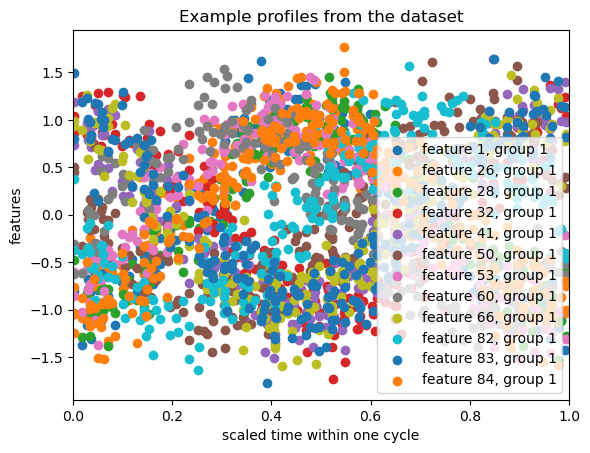

In [2]:
## Define dataset parameters
n_genes = 2000     # Total number of genes/transcripts in the synthetic dataset
n_samples = 200    # Number of samples used for training
n_test = 25        # Number of samples used for testing

# Initialize the data generator with the defined parameters
data = SyntheticData(n_genes, n_samples + n_test)

# Define oscillation frequencies in radians/hour
# Here, we are specifying a single rhythmic group.
data.oscillatory_groups(1)

# Generate the synthetic dataset
# - normal_dist_times=False: Times are uniformly spaced instead of normally distributed
# - rhy_frac=0.1: 10% of genes are rhythmic
X_synthetic, group_info, _ = data.generate_data(normal_dist_times=False, 
                                                    rhy_frac=0.1)

# Extract true sample times (used for validation later)
time = data.t  # True sample times that COFE does not "see" during analysis

# Add noise to the dataset
# st_dev=0.25 adds Gaussian noise with a standard deviation of 0.25
X = data.corrupt(X_synthetic, st_dev=0.25)

# Visualize the generated dataset
# group_info provides labels for rhythmic and arrhythmic genes
data.plot_X(X, group_info, [(1, 12)])

### Step 2: Data Preprocessing

In [3]:
## Split the dataset into training and testing sets
X_train = X[:, :n_samples].copy()  # Training data
X_test = X[:, n_samples:].copy()   # Testing data

# Standardize the dataset for analysis
# Z_train, Z_test: Standardized training and testing data
# features: Gene features used in analysis
# feature_std: Standard deviations of features for scaling
Z_train, Z_test, features, feature_std = COFE.analyse.preprocess_data(
    X_train, X_test, np.arange(n_genes), feature_dim='row', scale=True
)

# Check the true labels for rhythmic and arrhythmic genes
rhythmic_genes = group_info[1]    # Indices of truly rhythmic genes
arrhythmic_genes = group_info[0]  # Indices of truly arrhythmic genes

### Step 3: Running COFE Analysis

In [4]:
# Define candidate sparsity parameter values
s_choices = np.linspace(1, 30, 10)  # Range of sparsity parameters to evaluate

# Perform cross-validation to train the model
# - K=5: Number of folds for cross-validation
# - restarts=5: Number of restarts to ensure robustness
# - ncores=-1: Use all available CPU cores for parallel processing
# - repeats=3: Repeat cross-validation for stability
cv_results = COFE.analyse.cross_validate(
    Z_train, s_choices, features, K=5, feature_std=None, restarts=5, ncores=-1, 
    repeats=3
)

# Generate phase predictions for training data
# - period=1: Period of the rhythms on which true sample times are defined
train_results = COFE.analyse.predict_time(Z_train, cv_results, 
                                          true_times=time[:n_samples], 
                                          period=1.0)

# Generate phase predictions for testing data
test_results = COFE.analyse.predict_time(Z_test, cv_results, 
                                        true_times=time[n_samples:], 
                                        period=1.0)

### Step 4: Visualizing Results

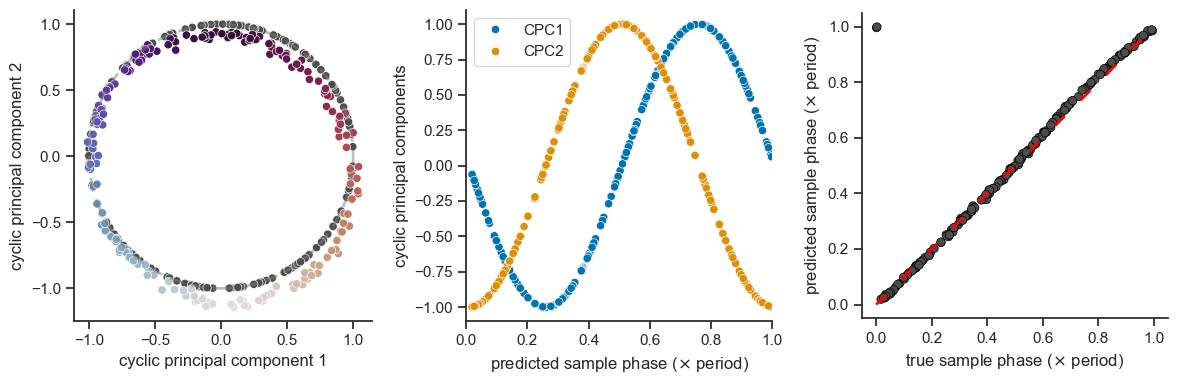

In [5]:
## Plot circular ordering of training data
# - period=1: Period of the rhythms on which true sample times are defined
COFE.plot.plot_circular_ordering(
    train_results, time=time[:n_samples], X=Z_train, figsize=(12, 4),
    period = 1.0
)

### Step 5: Evaluating Temporal Reordering Performance

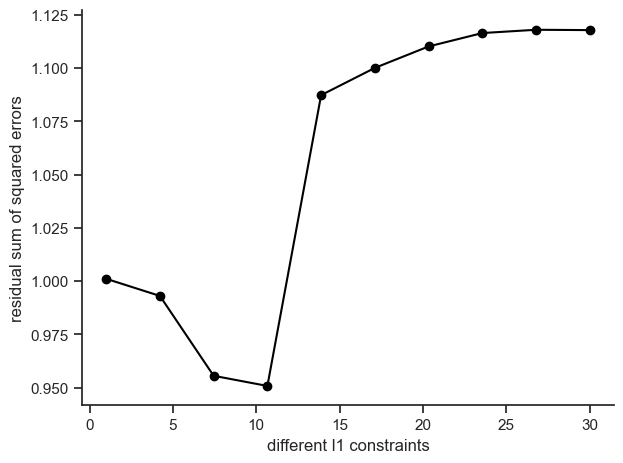

In [6]:
## Plot cross-validation results to find the optimal sparsity parameter
COFE.plot.plot_cv_run(train_results)

In [7]:
# Phase prediction accuracy (as a fraction of 24 hours)
train_mape = train_results['MAPE']  # Training data accuracy
test_mape = test_results['MAPE']    # Testing data accuracy
print(f"Training MAPE: {train_mape:1.4f}")
print(f"Testing MAPE: {test_mape:1.4f}")

Training MAPE: 0.0081
Testing MAPE: 0.0052


### Step 6: Extracting Biomarkers and Evaluating Its Accuracy

In [8]:
## Display the list of predicted rhythmic genes (biomarkers)
markers = COFE.plot.print_markers(train_results)

In [ ]:
# Performance of rhythmic feature identification using precision and recall
truth = [i in group_info[1] for i in np.arange(n_genes)]
prediction = [i in markers for i in np.arange(n_genes)]
print(f"Precision: {metrics.precision_score(truth, prediction):1.2f}, " 
       f"Recall: {metrics.recall_score(truth, prediction):1.2f}, " 
       f"Matthews correlation coefficient: {metrics.matthews_corrcoef(truth, prediction):1.2f}")

Precision: 1.00, recall: 1.00, Matthews correlation coefficient: 1.00


### Exploring COFE Functions

In [ ]:
# Use ? to get detailed documentation for any COFE function
# For example, to learn about the cross_validate function:
?COFE.analyse.cross_validate